In [4]:
pip install beautifulsoup4

Note: you may need to restart the kernel to use updated packages.


In [467]:
from bs4 import BeautifulSoup
import requests
import numpy as np
import pandas as pd
import html5lib
import datetime

## Part 1: Prep

### Step 1: Scrape

In [468]:
# get the url
# extract text
url = 'https://www.spaceweatherlive.com/en/solar-activity/top-50-solar-flares.html'
x = requests.get(url).text

# use bs4 to parse data as html
soup = BeautifulSoup(x, 'html.parser')
pretty = soup.prettify()

In [1064]:
# output

print(x)

<!doctype html>
<html lang="en">
    <head>
        <title>Top 50 solar flares | Solar activity | SpaceWeatherLive.com</title>
        <meta charset="utf-8" />
        <meta name="robots" content="index, follow, max-snippet:-1, max-image-preview:large, max-video-preview:-1">
        <meta name="description" content="On this page you will find an overview of the strongest solar flares since June 1996 together with links to more information in our archive and a v...">
        <meta name="keywords" content="SpaceWeatherLive, Live, Aurora, Auroral activity, Aurora Australis, Aurora Borealis, northern lights, Solar wind, Kp-index, Space Weather, Space Weather Updates, Aurora forecast, Space Weather Alerts, Solar activity, Solar flares, Sunspots, Aurora alert, Auroral activity, The Sun, SDO, STEREO, EPAM, DSCOVR">
        <!-- Facebook meta -->
        <meta property="og:url" content="https://spaceweatherlive.com/en/solar-activity/top-50-solar-flares.html">
        <meta property="og:type" c

In [865]:
# create list that contains all elements in table

data = []
for tr in soup.find("table",{"class":"table table-striped"}).find_all('tr'):
    row = [td.text for td in tr.find_all('td')]
    data.append(row)

In [1067]:
# create dataframe with appropriate columns for data

swlive = pd.DataFrame(data, columns=['rank', 'x_class', 'date', 'reg', 'start_time', 'max_time', 'end_time', 'movie'])

In [1068]:
# output

print(swlive)

    rank x_class        date   reg start_time max_time end_time  \
0   None    None        None  None       None     None     None   
1      1    X28+  2003/11/04  0486      19:29    19:53    20:06   
2      2    X20+  2001/04/02  9393      21:32    21:51    22:03   
3      3  X17.2+  2003/10/28  0486      09:51    11:10    11:24   
4      4    X17+  2005/09/07  0808      17:17    17:40    18:03   
5      5   X14.4  2001/04/15  9415      13:19    13:50    13:55   
6      6     X10  2003/10/29  0486      20:37    20:49    21:01   
7      7    X9.4  1997/11/06  8100      11:49    11:55    12:01   
8      8    X9.3  2017/09/06  2673      11:53    12:02    12:10   
9      9      X9  2006/12/05  0930      10:18    10:35    10:45   
10    10    X8.3  2003/11/02  0486      17:03    17:25    17:39   
11    11    X8.2  2017/09/10  2673      15:35    16:06    16:31   
12    12    X7.1  2005/01/20  0720      06:36    07:01    07:26   
13    13    X6.9  2011/08/09  1263      07:48    08:05    08:0

### Step 2: Tidy Up

In [1069]:
# drop unnecessary row using index value and column using name

swlive = swlive.drop(swlive.index[[0]])
swlive =  swlive.drop(['movie'], axis=1)

In [1070]:
# combine date and time col into 3 datetime cols
# no missing region values found here

# set 'date' col as index 
swlive = swlive.set_index('date')

# search cols for all cols that contain 'time'
cols = swlive.columns[swlive.columns.str.contains('time')]

# for each col in cols, combine date(as index) and time as datetime
for col in cols:
    swlive[col] = pd.to_datetime(swlive.index + swlive[col], format='%Y/%m/%d%H:%M')
    
# replace 'time' in cols with 'dt' to represent datetime  
swlive.columns = swlive.columns.str.replace('time','dt')
swlive = swlive.reset_index(drop=True)

In [1071]:
# output

print(swlive)

   rank x_class   reg            start_dt              max_dt  \
0     1    X28+  0486 2003-11-04 19:29:00 2003-11-04 19:53:00   
1     2    X20+  9393 2001-04-02 21:32:00 2001-04-02 21:51:00   
2     3  X17.2+  0486 2003-10-28 09:51:00 2003-10-28 11:10:00   
3     4    X17+  0808 2005-09-07 17:17:00 2005-09-07 17:40:00   
4     5   X14.4  9415 2001-04-15 13:19:00 2001-04-15 13:50:00   
5     6     X10  0486 2003-10-29 20:37:00 2003-10-29 20:49:00   
6     7    X9.4  8100 1997-11-06 11:49:00 1997-11-06 11:55:00   
7     8    X9.3  2673 2017-09-06 11:53:00 2017-09-06 12:02:00   
8     9      X9  0930 2006-12-05 10:18:00 2006-12-05 10:35:00   
9    10    X8.3  0486 2003-11-02 17:03:00 2003-11-02 17:25:00   
10   11    X8.2  2673 2017-09-10 15:35:00 2017-09-10 16:06:00   
11   12    X7.1  0720 2005-01-20 06:36:00 2005-01-20 07:01:00   
12   13    X6.9  1263 2011-08-09 07:48:00 2011-08-09 08:05:00   
13   14    X6.5  0930 2006-12-06 18:29:00 2006-12-06 18:47:00   
14   15    X6.2  0808 200

### Step 3: Get Nasa Data

In [1072]:
# get additional data about solar flares

url2 = 'https://cdaw.gsfc.nasa.gov/CME_list/radio/waves_type2.html'
y = requests.get(url2).text
soup_y = BeautifulSoup(y, 'html.parser')

In [1073]:
# extract the table from page 
# "PHTX' is in each row 
# use "PHTX" to create a list of strings for each row of table 

text_y = soup_y.get_text()
words = text_y.split('\n')
newlist = [x for x in words if "PHTX" in x]

In [1074]:
# create a dataframe from list by splitting each str into 16 respective values
# assign appropriate names for cols 

nasa = pd.DataFrame([i.split(maxsplit=15) for i in newlist],columns=['start_date','start_time','end_date','end_time','start_freq','end_freq','flare_loc','flare_reg','flare_imp','cme_date','cme_time','pos_angle','cme_width','cme_speed','plots','comments'])

In [1079]:
# output

nasa

,start_date,start_time,end_date,end_time,start_freq,end_freq,flare_loc,flare_reg,flare_imp,cme_date,cme_time,pos_angle,cme_width,cme_speed,plots,comments
0,1997/04/01,14:00,04/01,14:15,8000,4000,S25E16,8026,M1.3,04/01,15:18,74,79,312,PHTX,None
1,1997/04/07,14:30,04/07,17:30,11000,1000,S28E19,8027,C6.8,04/07,14:27,Halo,360,878,PHTX,None
2,1997/05/12,05:15,05/14,16:00,12000,80,N21W08,8038,C1.3,05/12,05:30,Halo,360,464,PHTX,None
3,1997/05/21,20:20,05/21,22:00,5000,500,N05W12,8040,M1.3,05/21,21:00,263,165,296,PHTX,None
4,1997/09/23,21:53,09/23,22:16,6000,2000,S29E25,8088,C1.4,09/23,22:02,133,155,712,PHTX,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,2017/09/10,16:02,09/11,06:50,16000,150,S09W92,-----,X8.3,09/10,16:00,Halo,360,3163,PHTX,onset has WAVES Data Gap
516,2017/09/12,07:38,09/12,07:43,16000,13000,N08E48,12680,C3.0,09/12,08:03,124,96,252,PHTX,uncertain
517,2017/09/17,11:45,09/17,12:35,16000,900,S08E170,-----,----,09/17,12:00,Halo,360,1385,PHTX,STEREO A data
518,2017/10/18,05:48,10/18,12:40,16000,400,S06E123,-----,----,10/18,08:00,85,146,1001,PHTX,"STEREO A data, faint in WIND"


### Step 4: Tidy Up Nasa

In [1080]:
# replace missing values with np.nan

nasa = nasa.replace(['------','-----', '----','--/--','---','--:--','????'], np.nan)

In [305]:
# create column to indicate if pos_angle row is halo or not

is_halo = []
for row in nasa['pos_angle']:
        if row =='Halo':
            is_halo.append('True')
        else:
            is_halo.append('False')

nasa['is_halo'] = is_halo   

# replace halo entries with np.nan

nasa = nasa.replace('Halo', np.nan)

In [1082]:
# create column to indicate if width is in lower bound 

# needs to be str type for iterrows 
nasa['cme_width'] = nasa['cme_width'].astype(str)

# create empty list to become width_lowerbound
width_lowerbound = []

# check each row in cme_width for '>'
# assign 'True' or 'False' to width_lowerbound
for index, row in nasa.iterrows():
    if '>' in row['cme_width']:
        width_lowerbound.append('True')
    else:
        width_lowerbound.append('False')

# assign width_lowerbound to a col in NASA
nasa['width_lowerbound'] = width_lowerbound 

In [1083]:
# remove '>' from cme_width

nasa['cme_width'] = nasa['cme_width'].str.replace('>', '')


In [1084]:
# end_date and cme_date only contain month and day
# add missing year

nasa['end_date'] = nasa['start_date'].str[:5] + nasa['end_date']
nasa['cme_date'] = nasa['start_date'].str[:5] + nasa['cme_date']

In [1085]:
# end_time contains some time coded as 1-24hrs instead of 0-23hrs
# 24:00 of day is equal to 00:00 of next day (midnight)

# this can't be turned into datetime
nasa['end_dt'] = nasa['end_date'] + ' ' + nasa['end_time']

# use timedelta to change all 24:00 to 00:00 
# change the corresponding date to the following day 
# now end_dt can be changed to datetime 
nasa[['date','time']] = nasa['end_dt'].str.split(expand=True)
nasa['end_dt'] = (pd.to_datetime(nasa.pop('date'), format='%Y/%m/%d') + 
                  pd.to_timedelta(nasa.pop('time') + ':00'))

In [1086]:
# combine start_date and start_time as datetime
# combine cme_date and cme_time as datetime 

nasa['start_dt'] = pd.to_datetime(nasa['start_date'] + ' ' + nasa['start_time'])
nasa['cme_dt'] = pd.to_datetime(nasa['cme_date'] + ' ' + nasa['cme_time'])

In [1087]:
# drop unnecessary columns 

nasa = nasa.drop(['start_time', 'end_time', 'cme_time', 'cme_date', 'start_date', 'end_date'], axis=1)

In [ ]:
# output

## Part 2: Analysis

### Question 1: Replication

In [615]:
# x class solar flare is biggest

In [959]:
# try to sort flare_imp by descending order to get top 50 
# X class flare is the biggest (M class is medium, C class is small)

# change type to str to get all X class flare in data
# don't need M or C class because they're small 
nasa['flare_imp'] = nasa['flare_imp'].astype(str)
nasa_flares = nasa[nasa['flare_imp'].str.contains('X')].copy()

# get rid of 'X' first to isolate the numeric value
nasa_flares['flare_imp'] = nasa_flares['flare_imp'].str.replace('X', '')

In [960]:
# change flare_imp to float to sort 

nasa_flares['flare_imp'] = nasa_flares['flare_imp'].astype(float)
nasa_sort = nasa_flares.sort_values(by=['flare_imp'], ascending=False)

In [961]:
# get top 50
nasa_sort_flares = nasa_sort.head(50).copy()

# change back to str to add 'X'
nasa_sort_flares['flare_imp'] = nasa_sort_flares['flare_imp'].astype(str)
nasa_sort_flares['flare_imp'] = 'X' + nasa_sort_flares['flare_imp']
nasa_sort_flares = nasa_sort_flares.reset_index(drop=True)

The top 50 solar flares from the NASA data contains matches with the SpaceWeatherLive data, but it is not an exact replica. For example, the top 50 solar flares from NASA contains solar flares classed as X2.5 or lower while the data from SpaceWeatherLive does not contain any solar flares below X2.6.

### Question 2: Integration

In [962]:
# flare class in NASA not recorded the same way as SpaceWeatherLive 
## X17 in NASA data is recorded as X17.2+ in SpaceWeatherLive 
# some reg in NASA coded with additional 1 in front (10486 vs 0486) 

# use start dates to match instead of flare class or reg for consistency
nasa_sort_flares['date_nasa'] = nasa_sort_flares['start_dt'].dt.date
swlive['date_swl'] = swlive['start_dt'].dt.date

In [969]:
# create new col in nasa_sort_flares 
# use dictionary to map through date_nasa for date_swl matches 
# if match exists, rank_in_swl is corresponding rank in swl or fill no_match

def get_match(df, dct):
    dct = dict(zip(swlive['date_swl'], swlive['rank']))
    df['rank_in_swl']=df['date_nasa'].map(maps).fillna('no_match')
    return df

There are irregularities between the ways NASA and Space Weather Live classify solar flares. For example, X17 in the NASA data is recorded as X17.2+ in Space Weather Live even though the location code and the corresponding dates are the same. There are also differences between the way region is coded, but the region of each row is not a unique identifier. I am defining a best match between the two datasets as a match between the date portion of the start datetime of the respective datasets. For example, if some row in 'date_nasa' and 'date_swl' match, then I can infer that the rest of the row should be a match. 

In [970]:
# create dictionary of swl cols date_swl and rank 
maps = dict(zip(swlive['date_swl'], swlive['rank']))

# call function
get_match(nasa_sort_flares, maps)

,start_freq,end_freq,flare_loc,flare_reg,flare_imp,pos_angle,cme_width,cme_speed,plots,comments,is_halo,width_lowerbound,end_dt,start_dt,cme_dt,date_nasa,rank_in_swl
0,10000,200,S19W83,10486,X28.0,NaN,360,2657,PHTX,None,True,False,2003-11-05 00:00:00,2003-11-04 20:00:00,2003-11-04 19:54:00,2003-11-04,1
1,14000,250,N19W72,9393,X20.0,261,244,2505,PHTX,None,False,False,2001-04-03 02:30:00,2001-04-02 22:05:00,2001-04-02 22:06:00,2001-04-02,2
2,14000,40,S16E08,10486,X17.0,NaN,360,2459,PHTX,None,True,False,2003-10-30 00:00:00,2003-10-28 11:10:00,2003-10-28 11:30:00,2003-10-28,3
3,14000,40,S20W85,9415,X14.0,245,167,1199,PHTX,None,False,False,2001-04-16 13:00:00,2001-04-15 14:05:00,2001-04-15 14:06:00,2001-04-15,5
4,11000,500,S15W02,10486,X10.0,NaN,360,2029,PHTX,None,True,False,2003-10-30 00:00:00,2003-10-29 20:55:00,2003-10-29 20:54:00,2003-10-29,6
5,14000,100,S18W63,8100,X9.4,NaN,360,1556,PHTX,None,True,False,1997-11-07 08:30:00,1997-11-06 12:20:00,1997-11-06 12:10:00,1997-11-06,7
6,16000,70,S08W33,12673,X9.3,NaN,360,1571,PHTX,None,True,False,2017-09-07 08:00:00,2017-09-06 12:05:00,2017-09-06 12:24:00,2017-09-06,8
7,14000,250,S07E68,10930,X9.0,NaN,nan,NaN,PHTX,LASCO_DATA_GAP,False,False,2006-12-05 20:00:00,2006-12-05 10:50:00,NaT,2006-12-05,9
8,12000,250,S14W56,10486,X8.3,NaN,360,2598,PHTX,None,True,False,2003-11-03 01:00:00,2003-11-02 17:30:00,2003-11-02 17:30:00,2003-11-02,10
9,16000,150,S09W92,NaN,X8.3,NaN,360,3163,PHTX,onset has WAVES Data Gap,True,False,2017-09-11 06:50:00,2017-09-10 16:02:00,2017-09-10 16:00:00,2017-09-10,11


### Question 3

In [992]:
import matplotlib.pyplot as plt

In [901]:
# number of flares with halo in NASA top 50 and NASA data
IsTrue = [(len(nasa_sort_flares[nasa_sort_flares['is_halo'] == 'True'])),len(nasa[nasa['is_halo'] == 'True']) - (len(nasa_sort_flares[nasa_sort_flares['is_halo'] == 'True']))]

# number of flares without halo in NASA top 50 and NASA data
IsFalse = [len(nasa_sort_flares[nasa_sort_flares['is_halo'] == 'False']), len(nasa[nasa['is_halo'] == 'False']) - len(nasa_sort_flares[nasa_sort_flares['is_halo'] == 'False'])]

In [902]:
# percent of flares with halos in NASA top 50 and NASA data
p_true = np.array([IsTrue[0]/(len(nasa_sort_flares)) * 100, IsTrue[1]/(len(nasa) - len(nasa_sort_flares)) * 100]) 

# percent of flares without halos in NASA top 50 and NASA data
p_false = np.array([IsFalse[0]/(len(nasa_sort_flares)) * 100, IsFalse[1]/(len(nasa) - len(nasa_sort_flares)) * 100])

The intent of my plot is to compare Halo CMEs in the top 50 flares to the rest of the solar flares in the NASA data. Since the record of Halo CMEs is a categorical variable, I will use a stacked barchart. By using a stacked barchart, I plan to visualize the proportion of Halo CMEs in the top 50 flares vs the proportion of Halo CMEs in the rest of the data.

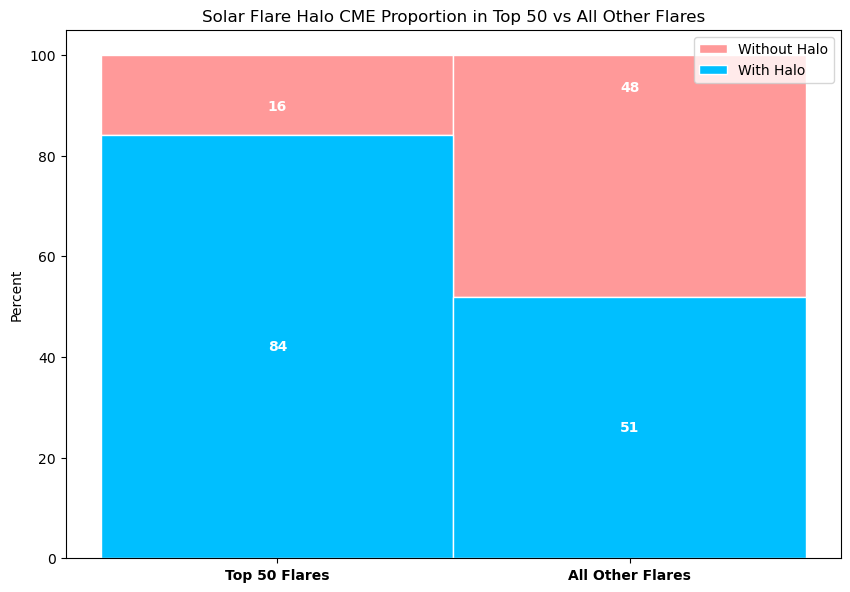

In [1063]:
# label for xticks
Top50 = ["Top 50 Flares", "All Other Flares"]
    
#add colors
colors = ['#FF9999', '#00BFFF']

# position of the bars on the x-axis
# number of xticks
r = range(len(Top50))
barWidth = 1

#plot bars
plt.figure(figsize=(10,7))
# with halo is on bottom half 
# without halo is on top half
ax1 = plt.bar(r, p_false, bottom=proportion_true, color=colors[0], edgecolor='white', width=barWidth, label="Without Halo")
ax2 = plt.bar(r, p_true, color=colors[1], edgecolor='white', width=barWidth, label='With Halo')
plt.legend()
plt.title('Solar Flare Halo CME Proportion in Top 50 vs All Other Flares')
plt.xticks(r, Top50, fontweight='bold')
plt.ylabel("Percent")
for r1, r2 in zip(ax1, ax2):
    h1 = r1.get_height()
    h2 = r2.get_height()
    plt.text(r1.get_x() + r1.get_width() / 2., h1 + h2/1.14, "%d" % h1, ha="center", va="center", color="white", fontsize=10, fontweight="bold")
    plt.text(r2.get_x() + r2.get_width() / 2., h2 / 2., "%d" % h2, ha="center", va="center", color="white", fontsize=10, fontweight="bold")

plt.show()

My stacked barchart compares the proportion of Halo CMEs recorded in the solar flares classified as the top 50 most powerful to the proportion of Halo CMEs recorded in all other flares. The y axis represents the percentage from 0 to 100. The blue segment of the bars represent the percentage of solar flares with Halo CMEs in the top 50 data and in the other solar flares. The red segment represents the percentage of solar flares that did not have Halo CMEs in the top 50 data and in the other solar flares. In total, the percent of flares with Halo CMEs and the percent of flares without Halo CMEs is equal to 100 in both bars. 

From the plot, we can see that the proportion of solar flares with Halo CMEs in the top 50 solar flares is far greater than the proportion of solar flares with Halo CMEs in the rest of the flares. The percentage of solar flares not in the top 50 with Halo CMEs is 51% compared to 84% in the top 50 flares. Halo CMEs occur with greater frequency in more powerful solar flares (at least X class solar flare like in the top 50 flares) than in lower class flares.